# <font style="font-size: 26px;" color='red'> Brain MRI Detector & Segmentation using Attention U-Net</font>

## <font style="font-size: 18px;" color='green'>Introduction</font>
<span style="font-size: 13px;">
**U-Net** is an architecture developed by Olaf Ronneberger and his team at the University of Freiburg in 2015 for biomedical image segmentation. It is a highly popular approach for semantic segmentation tasks. It is a fully convolutional neural network that is designed to learn from fewer training samples. This architecture is an improvement over the existing FCN (Fully convolutional networks for semantic segmentation) developed by Jonathan Long and his team in 2014.
</span>

## <font style="font-size: 18px;" color='green'>UNET Architecture for Image Segmentation</font>
<span style="font-size: 13px;">

UNET is a U-shaped deep learning model used for semantic image segmentation. It consists of an encoder (contracting path), a decoder (expanding path), and a bridge connecting them.
</span>

### <font style="font-size: 16px;" color='blue'>1. U-Shaped Structure</font>
- <font style="font-size: 14px;" color='black'><b>Encoder (Contracting Path)</b></font>:<span style="font-size: 13px;">
 Extracts features from the input image by reducing spatial dimensions and increasing feature channels.</span>
- <font style="font-size: 14px;" color='black'><b> Decoder (Expanding Path)</b></font>:<span style="font-size: 13px;">
 Reconstructs the image and outputs the segmentation mask.</span>
- <font style="font-size: 14px;" color='black'><b>Bridge</b></font>:<span style="font-size: 13px;">
 Connects the encoder and decoder, facilitating the flow of information.</span>
![Segmentation de Tumeur](../Images/unet.png)

### <font style="font-size: 14px;" color='blue'>2. Encoder</font><span style="font-size: 13px;">
The encoder learns abstract features from the input image by progressively reducing its spatial dimensions and increasing the number of feature channels.</span>
<span style="font-size: 13px;">

- **Block Structure**:
  - Two **3×3 convolutions** followed by **ReLU** activation.
  - A **2×2 max-pooling** operation reduces the spatial dimensions by half.
  
- **Goal**: Extract hierarchical features while reducing the spatial dimensions.
</span>

### <font style="font-size: 16px;" color='blue'>3. Skip Connections</font>
<span style="font-size: 13px;">
- Skip connections pass feature maps directly from the encoder to the corresponding decoder block.
- **Benefits**:
  - Prevent loss of spatial information.
  - Improve gradient flow during backpropagation.
  - Help the decoder reconstruct fine details of the image for more precise segmentation.
</span>

### <font style="font-size: 16px;" color='blue'>4. Bridge</font>
<span style="font-size: 13px;">
- The bridge connects the encoder and decoder.
- It consists of two **3×3 convolutions** with **ReLU** activation.
</span>

### <font style="font-size: 16px;" color='blue'>5. Decoder</font>
<span style="font-size: 13px;">
The decoder reconstructs the image by increasing the spatial resolution and generates the segmentation mask.

- **Block Structure**:
  - Starts with a **2×2 transpose convolution** (deconvolution) to increase spatial dimensions.
  - The feature map is **concatenated** with the corresponding encoder feature map.
  - Two **3×3 convolutions** followed by **ReLU** activation.
  
- **Final Output**:
  - A **1×1 convolution** with **sigmoid** activation produces the segmentation mask.
  - **Sigmoid** outputs values between 0 and 1, representing pixel-wise class probabilities.
  </span>
![Segmentation de Tumeur](../Images/unet-min-jpg.webp)


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install kaggle

In [ ]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

In [ ]:

def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()

patient_id                        images  \
0  TCGA_DU_6399_19830416  TCGA_DU_6399_19830416_52.tif   
1  TCGA_DU_6399_19830416  TCGA_DU_6399_19830416_11.tif   
2  TCGA_DU_6399_19830416  TCGA_DU_6399_19830416_53.tif   
3  TCGA_DU_6399_19830416  TCGA_DU_6399_19830416_23.tif   
4  TCGA_DU_6399_19830416  TCGA_DU_6399_19830416_20.tif   

                               masks  diagnosis  
0  TCGA_DU_6399_19830416_52_mask.tif          0  
1  TCGA_DU_6399_19830416_11_mask.tif          0  
2  TCGA_DU_6399_19830416_53_mask.tif          0  
3  TCGA_DU_6399_19830416_23_mask.tif          1  
4  TCGA_DU_6399_19830416_20_mask.tif          1

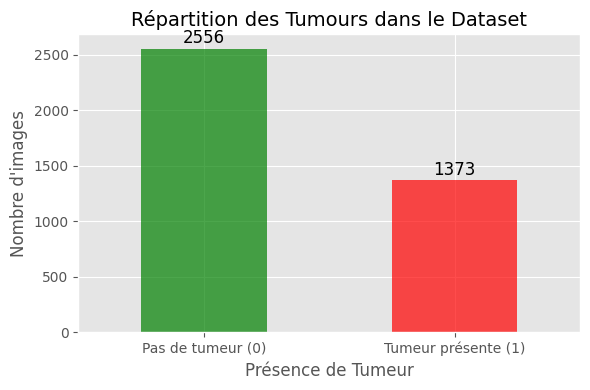

In [35]:
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
pip install imageio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


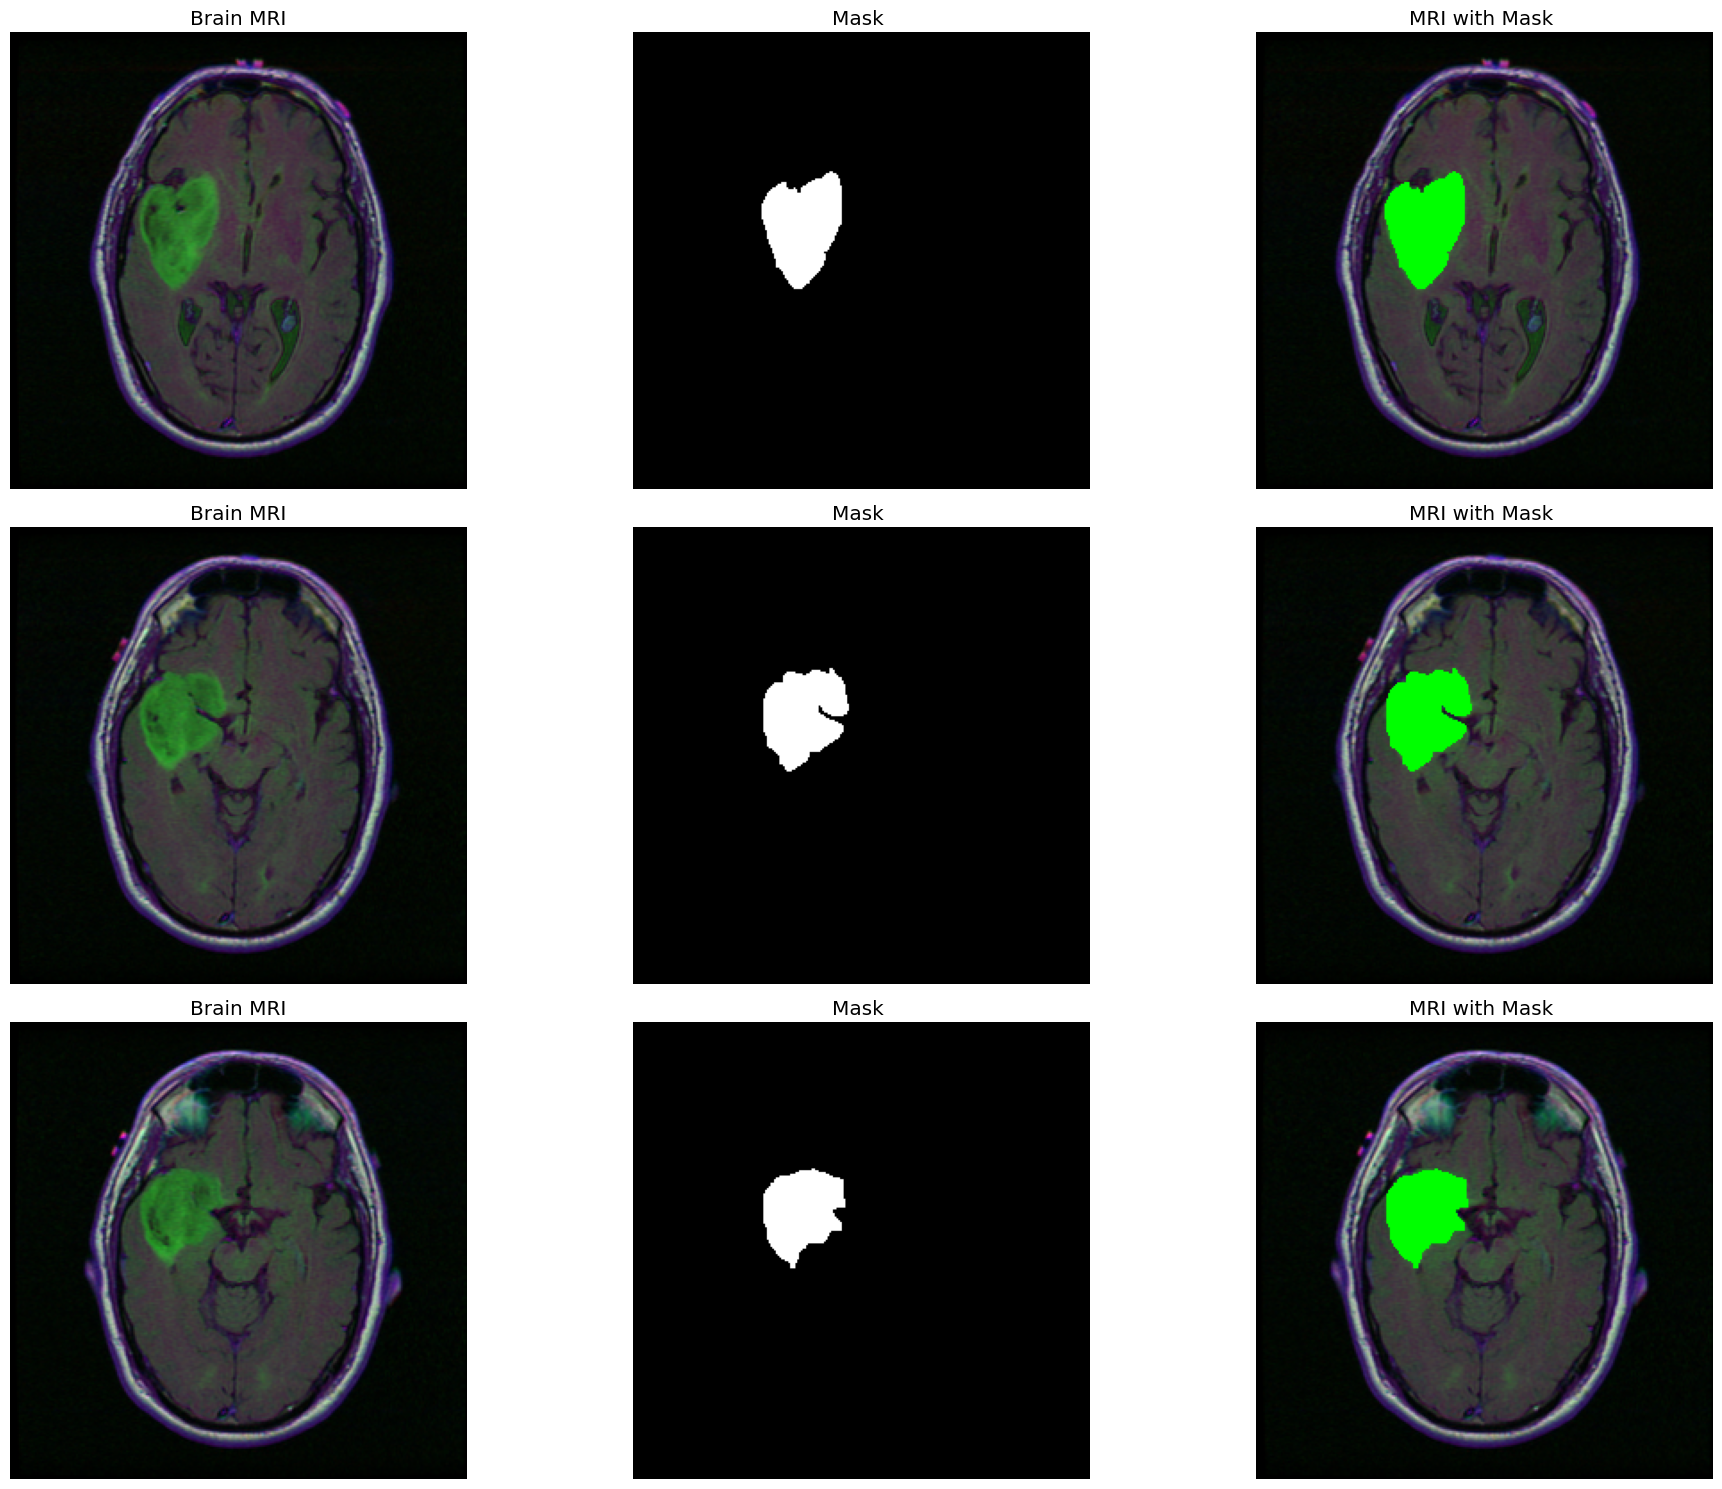

In [37]:

count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path)  
        mask = imread(mask_path) 

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()

In [ ]:

train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)
train, val = train_test_split(train, test_size=0.1, random_state=25)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(train.head())

Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
2754  TCGA_HT_7881_19981015  TCGA_HT_7881_19981015_21.tif   
1556  TCGA_HT_7616_19940813  TCGA_HT_7616_19940813_17.tif   
1620  TCGA_HT_7884_19980913  TCGA_HT_7884_19980913_15.tif   
1067  TCGA_HT_8114_19981030   TCGA_HT_8114_19981030_6.tif   
3616  TCGA_FG_6689_20020326  TCGA_FG_6689_20020326_48.tif   

                                  masks  diagnosis  
2754  TCGA_HT_7881_19981015_21_mask.tif          0  
1556  TCGA_HT_7616_19940813_17_mask.tif          1  
1620  TCGA_HT_7884_19980913_15_mask.tif          0  
1067   TCGA_HT_8114_19981030_6_mask.tif          0  
3616  TCGA_FG_6689_20020326_48_mask.tif          0  


In [39]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [40]:
def adjust_data(img, mask):
    img = img / 255  
    mask = mask / 255  
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images", 
        class_mode=None,  
        color_mode=image_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks",  
        class_mode=None, 
        color_mode=mask_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir, 
        save_prefix=mask_save_prefix,
        seed=seed
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask)  
        yield img, mask

In [41]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train,  
    batch_size=32,    
    aug_dict=data_augmentation, 
    target_size=(256, 256) )
train.head()

patient_id  \
2754  TCGA_HT_7881_19981015   
1556  TCGA_HT_7616_19940813   
1620  TCGA_HT_7884_19980913   
1067  TCGA_HT_8114_19981030   
3616  TCGA_FG_6689_20020326   

                                                 images  \
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0

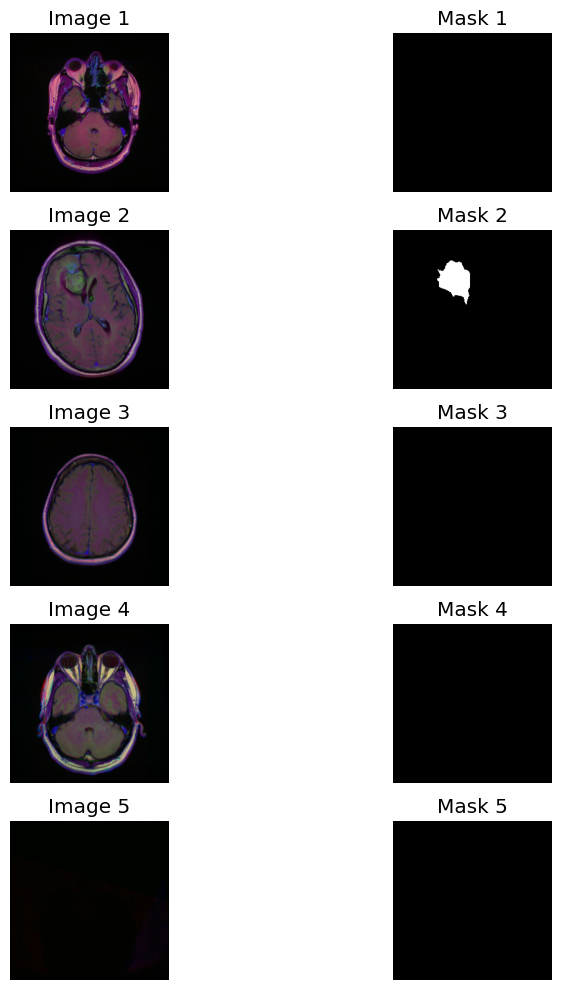

In [42]:

num_images_to_show = 5  
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images']
    mask_path = train.iloc[i]['masks']  
    
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()

In [43]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val,  
    batch_size=32,     
    aug_dict={},         
    target_size=(256, 256) 
)

In [ ]:
small_train_df = train.sample(n=10) 
small_train_generator = data_generator(
    data_frame=small_train_df,  
    batch_size=2,      
    aug_dict=data_augmentation, 
    target_size=(256, 256)
)

sample_small_batch = next(small_train_generator)

print("Small batch image shape:", sample_small_batch[0].shape)
print("Small batch mask shape:", sample_small_batch[1].shape)

Found 10 validated image filenames.
Found 10 validated image filenames.
Small batch image shape: (2, 256, 256, 3)
Small batch mask shape: (2, 256, 256, 1)


In [45]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)
    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [46]:
model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[

 Total params: 31,044,365 (118.42 MB)

 Trainable params: 31,038,601 (118.40 MB)

 Non-trainable params: 5,764 (22.52 KB)

In [ ]:
smooth = 100

def iou_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou

def dice_coefficient(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [48]:

lr_reduction = ReduceLROnPlateau(monitor='val_dice_coefficient', patience=8, verbose=1, factor=0.4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

In [ ]:
learning_rate = 1e-3
from tensorflow.keras.metrics import Recall, Precision

model.compile(
    optimizer=Adam(learning_rate=learning_rate, ), 
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou_score, Recall(), Precision()]
)
steps_per_epoch = int(len(train) / 32)
validation_steps = int(len(val) / 32)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_reduction, early_stop, model_checkpoint]
)


82
9
Found 2651 validated image filenames.
Found 2651 validated image filenames.
Epoch 1/100


I0000 00:00:1731967038.543520     160 service.cc:145] XLA service 0x7d285800a5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731967038.543596     160 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731967114.142230     160 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - dice_coefficient: 0.0347 - iou_score: 0.0177 - loss: 0.9653 - precision: 0.0480 - recall: 0.9060Found 295 validated image filenames.
Found 295 validated image filenames.
82/82 ━━━━━━━━━━━━━━━━━━━━ 162s 926ms/step - dice_coefficient: 0.0347 - iou_score: 0.0178 - loss: 0.9653 - precision: 0.0482 - recall: 0.9060 - val_dice_coefficient: 0.0284 - val_iou_score: 0.0144 - val_loss: 0.9716 - val_precision: 0.0261 - val_recall: 0.9991
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 143s 992ms/step - dice_coefficient: 0.0356 - iou_score: 0.0182 - loss: 0.9643 - precision: 0.1070 - recall: 0.8753 - val_dice_coefficient: 0.0336 - val_iou_score: 0.0172 - val_loss: 0.9698 - val_precision: 0.1283 - val_recall: 0.6184
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 890ms/step - dice_coefficient: 0.0400 - iou_score: 0.0205 - loss: 0.9601 - precision: 0.1171 - recall: 0.9215 - val_dice_coefficient: 0.0335 - val_iou_score: 0.0171 - val_loss: 0.9670 - val_precision: 0.0356 - 

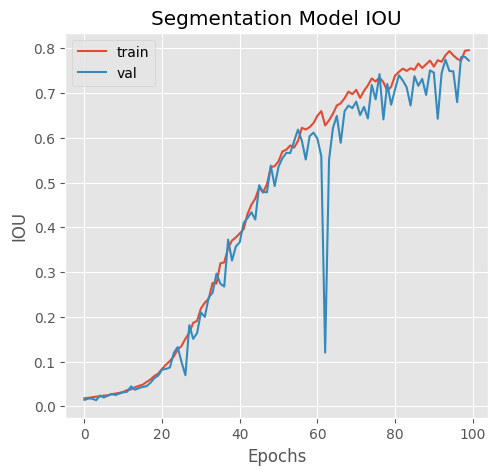

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou_score']);
plt.plot(history.history['val_iou_score']);
plt.title("Segmentation Model IOU");
plt.ylabel("IOU");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

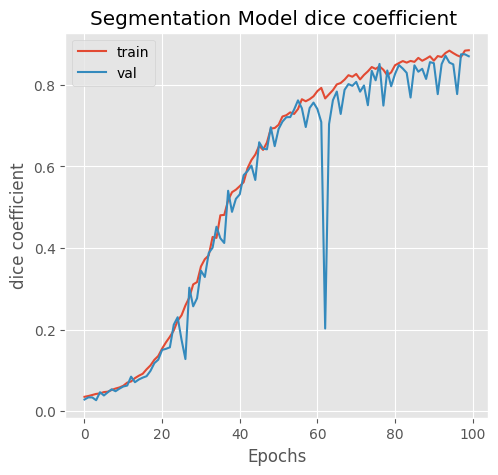

In [52]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dice coefficient ");
plt.ylabel("dice coefficient");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

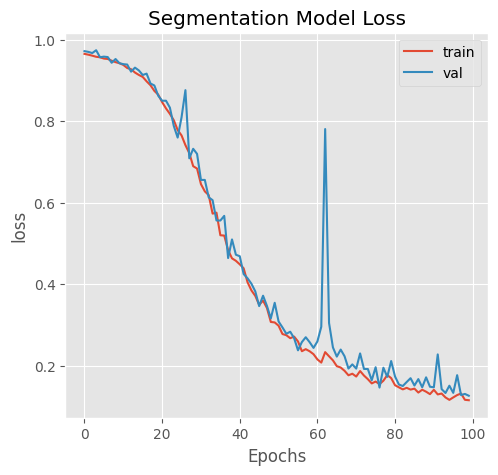

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [54]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())

                 patient_id  \
1006  TCGA_DU_8167_19970402   
1217  TCGA_HT_A61B_19991127   
3267  TCGA_HT_8106_19970727   
2033  TCGA_HT_8105_19980826   
3419  TCGA_FG_7634_20000128   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  


In [ ]:
import tensorflow as tf
import numpy as np

def combined_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",   
    class_mode=None,  
    color_mode="rgb", 
    target_size=(256, 256), 
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="masks",   
    class_mode=None,  
    color_mode="grayscale", 
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32  

test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")


Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - dice_coefficient: 0.8750 - iou_score: 0.7793 - loss: 0.1250 - precision: 0.9040 - recall: 0.8949
Test Loss: 0.12683282792568207
Test Dice Coefficient: 0.8731671571731567
Test IoU: 0.7766336798667908
Test Recall: 0.8849073648452759
Test Precision: 0.9084744453430176


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


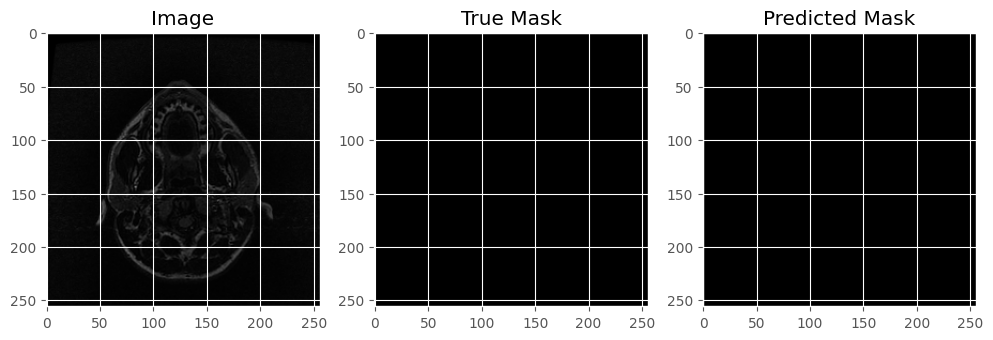

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


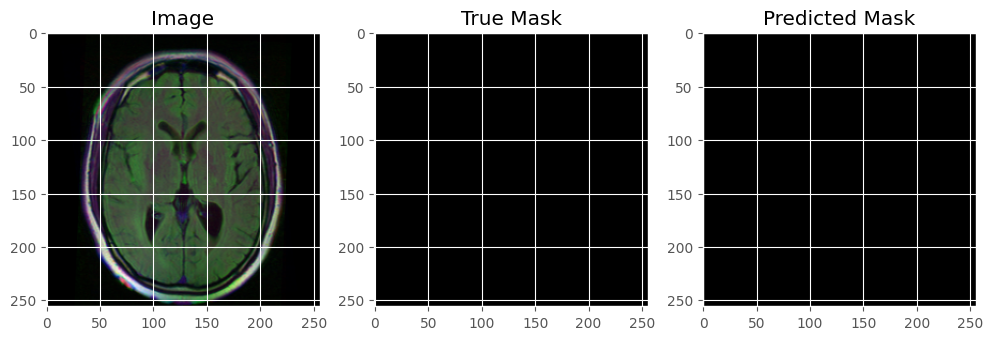

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


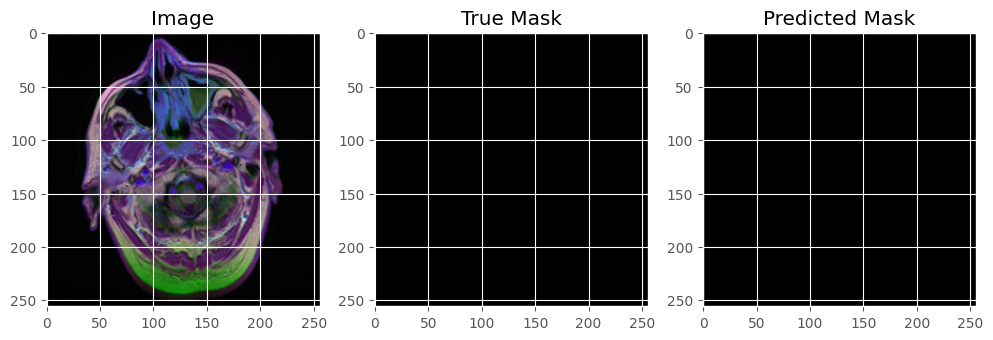

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


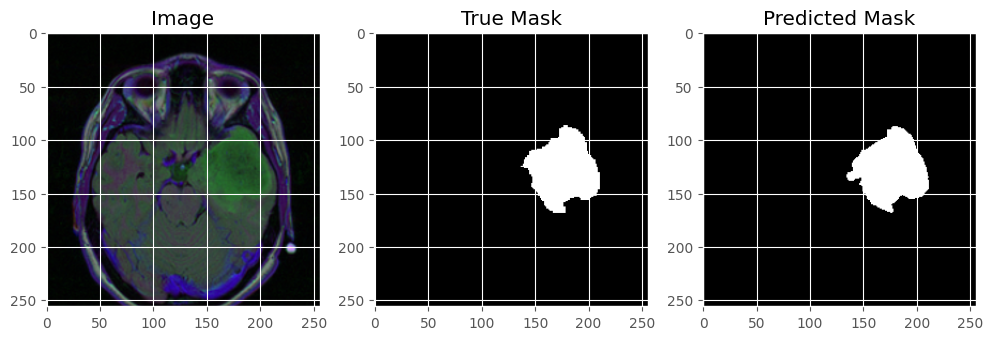

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


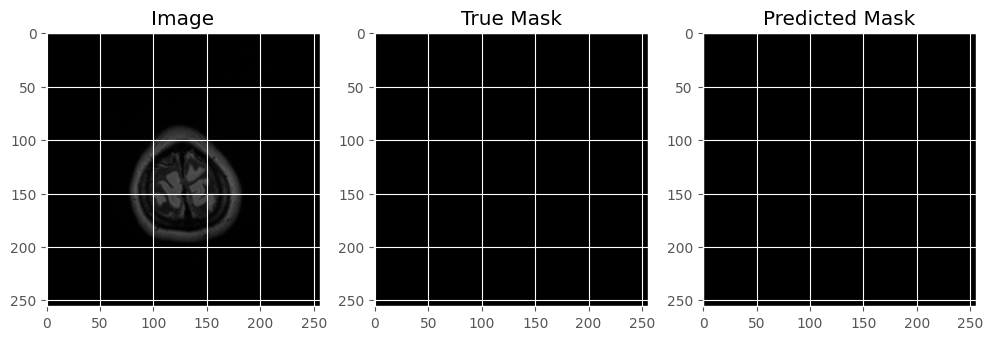

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


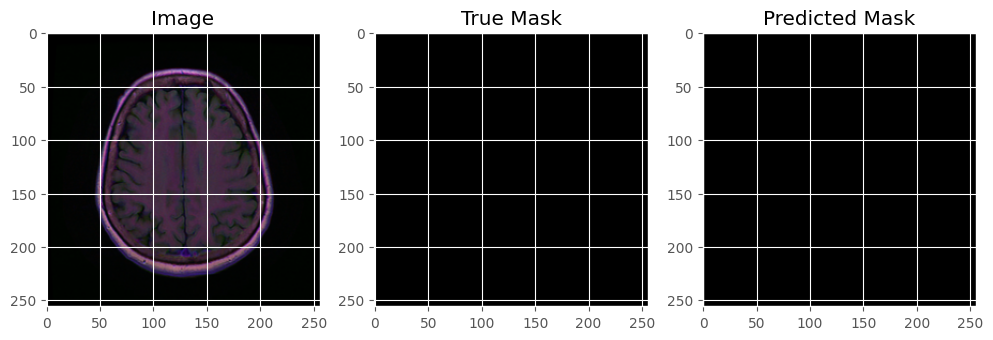

In [58]:

for i in range(6):
    image, mask = next(test_generator)
    
    predicted_mask = model.predict(image)

    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()

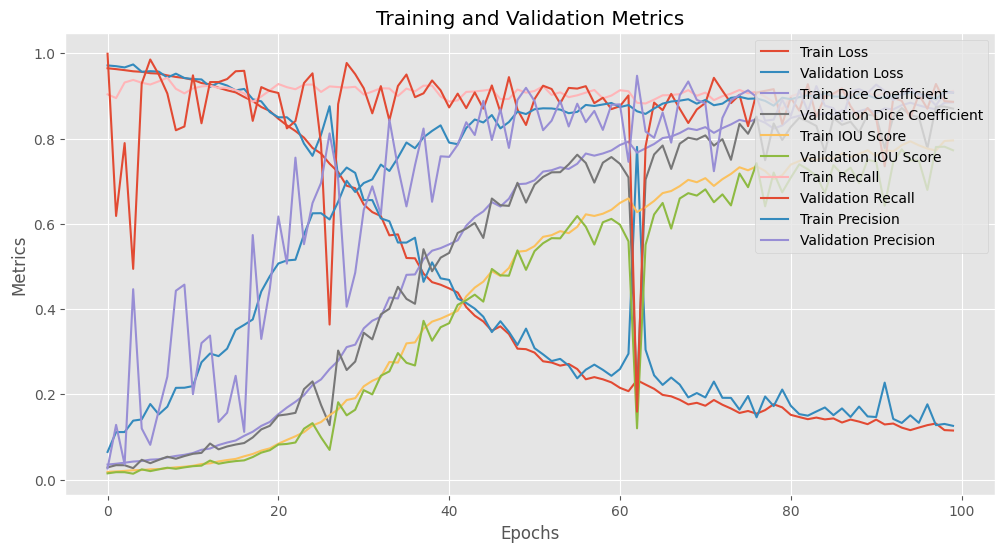

In [ ]:
plt.figure(figsize=(12, 6))

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tracer Dice Coefficient
if 'dice_coefficient' in history.history:
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
if 'val_dice_coefficient' in history.history:
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')

# Tracer IOU Score
if 'iou_score' in history.history:
    plt.plot(history.history['iou_score'], label='Train IOU Score')
if 'val_iou_score' in history.history:
    plt.plot(history.history['val_iou_score'], label='Validation IOU Score')

# Tracer Recall
if 'recall' in history.history:
    plt.plot(history.history['recall'], label='Train Recall')
if 'val_recall' in history.history:
    plt.plot(history.history['val_recall'], label='Validation Recall')

# Tracer Precision
if 'precision' in history.history:
    plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')

plt.title("Training and Validation Metrics")
plt.ylabel("Metrics")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.grid(True)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


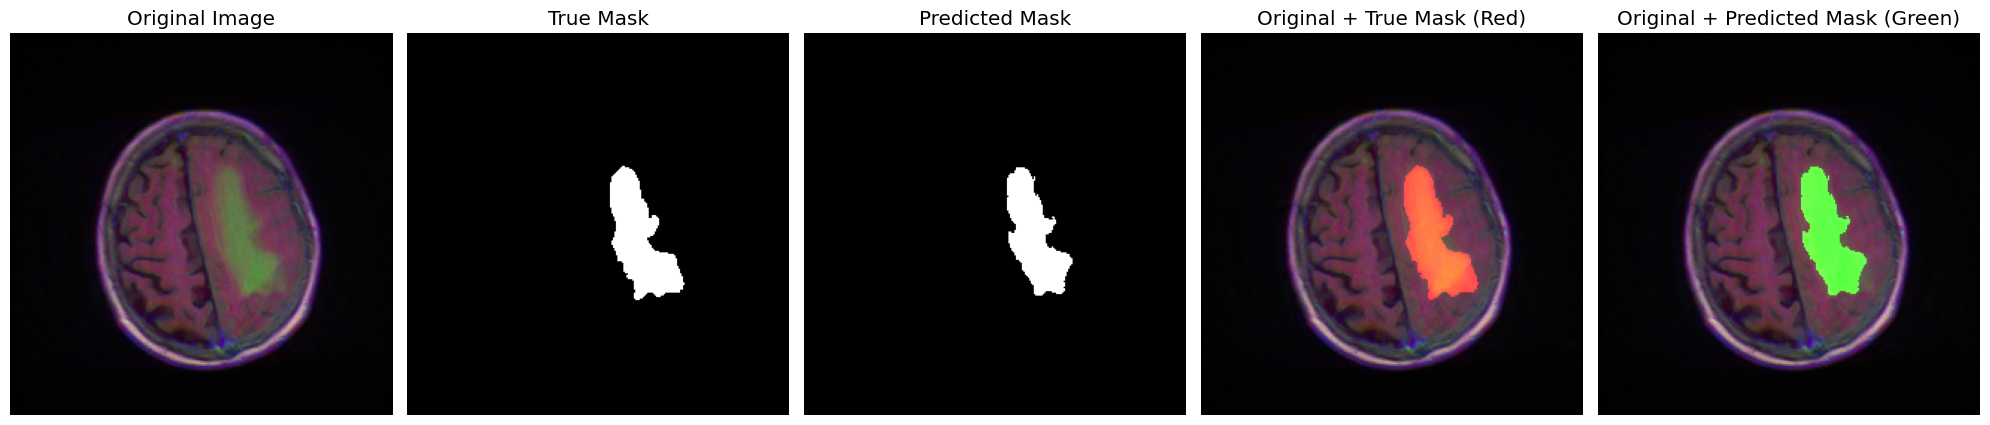

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


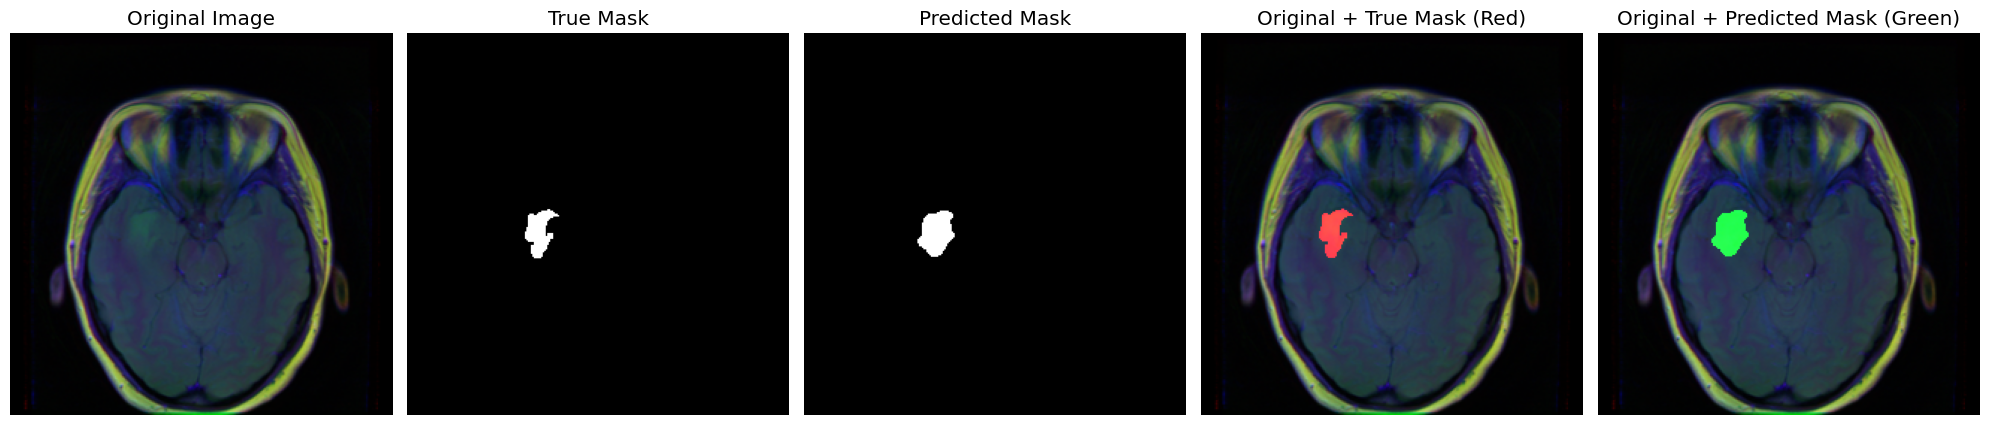

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


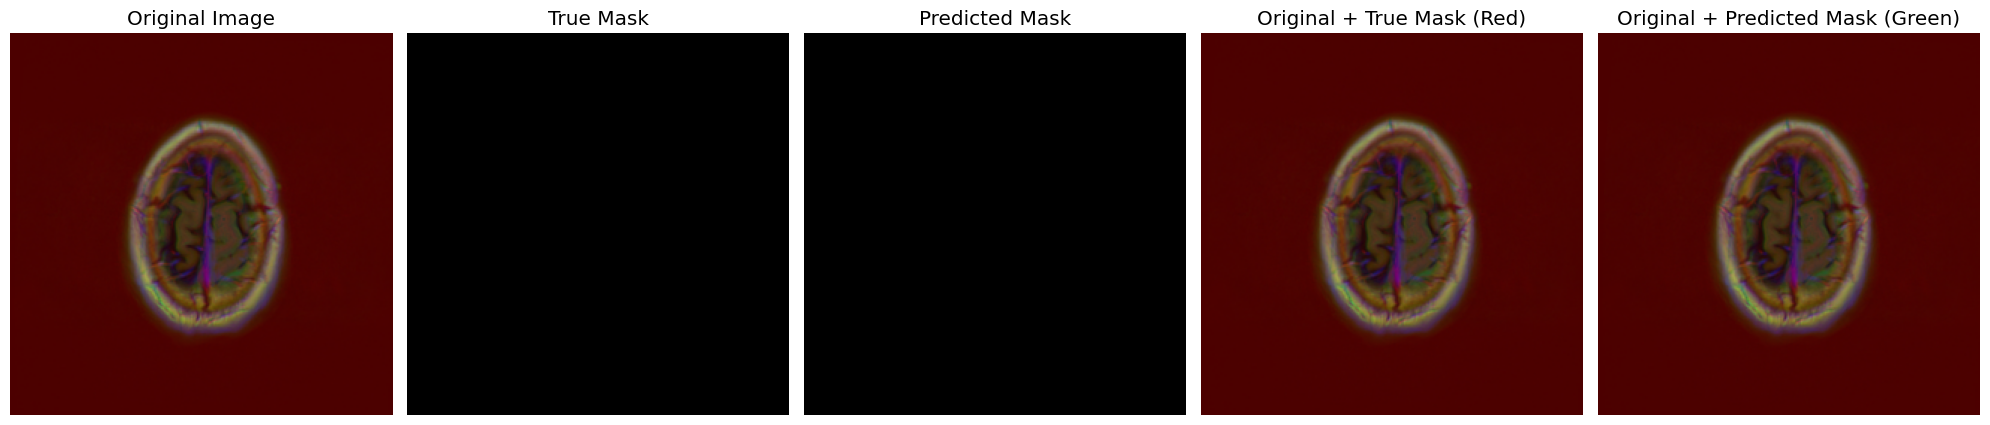

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


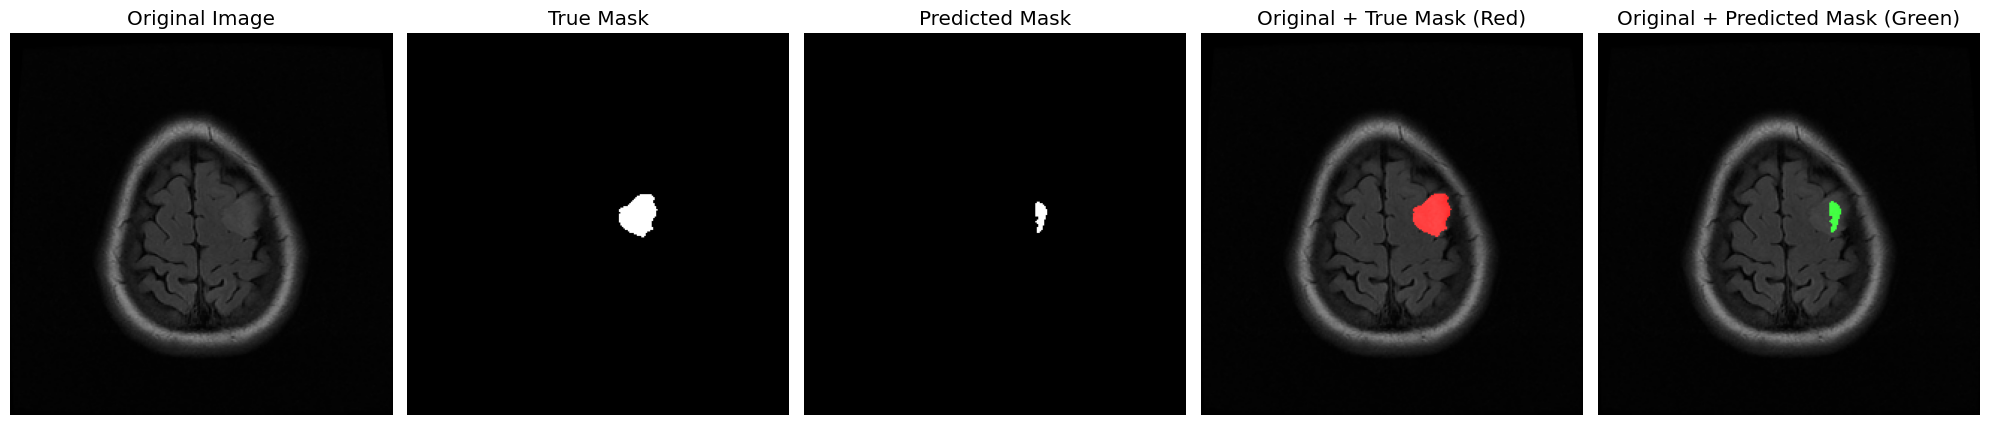

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


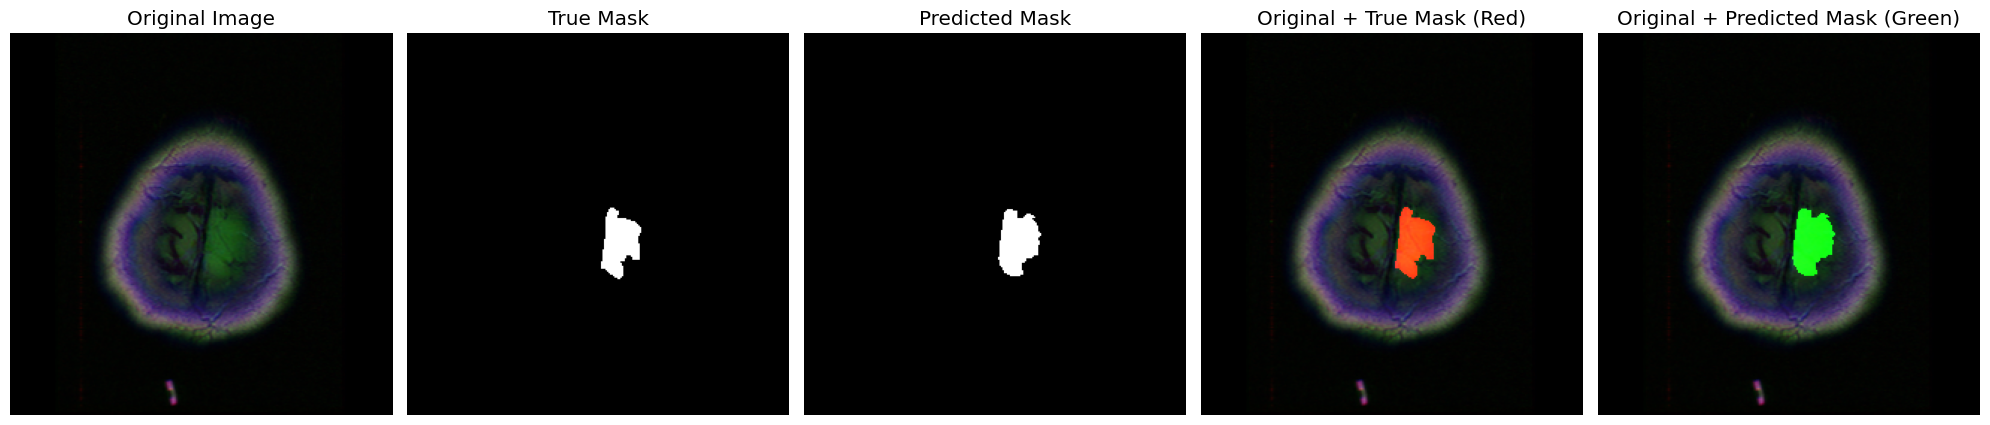

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


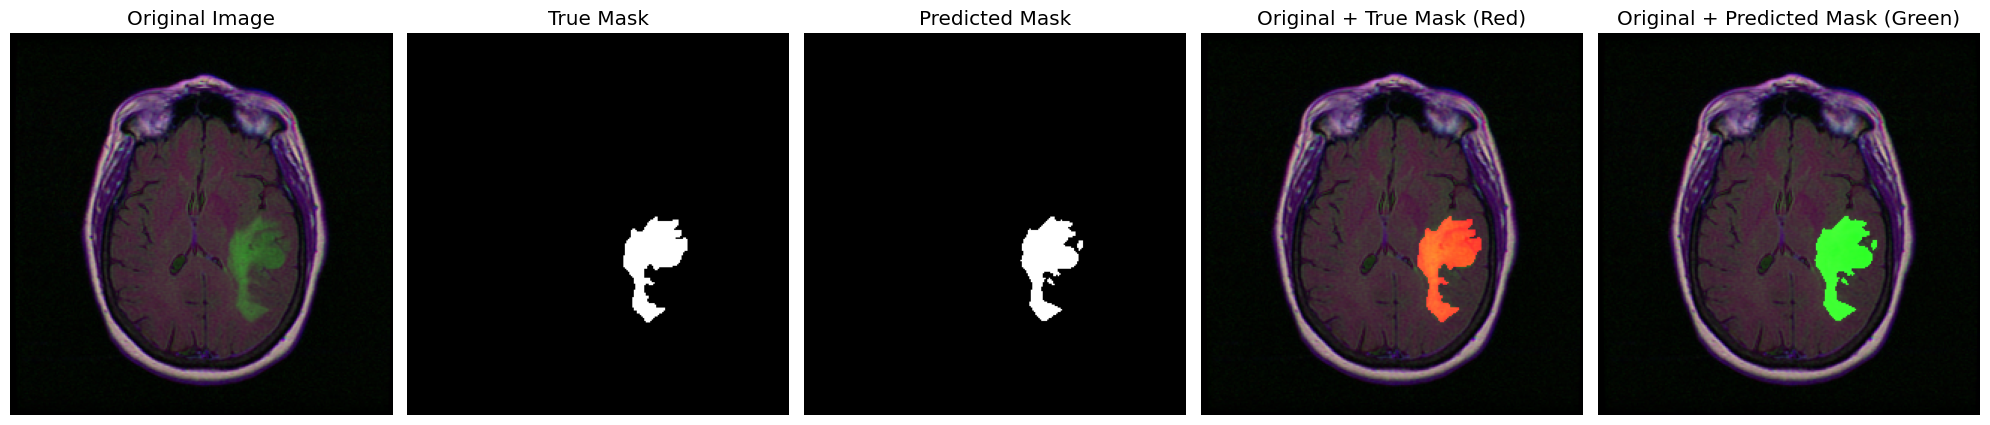

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


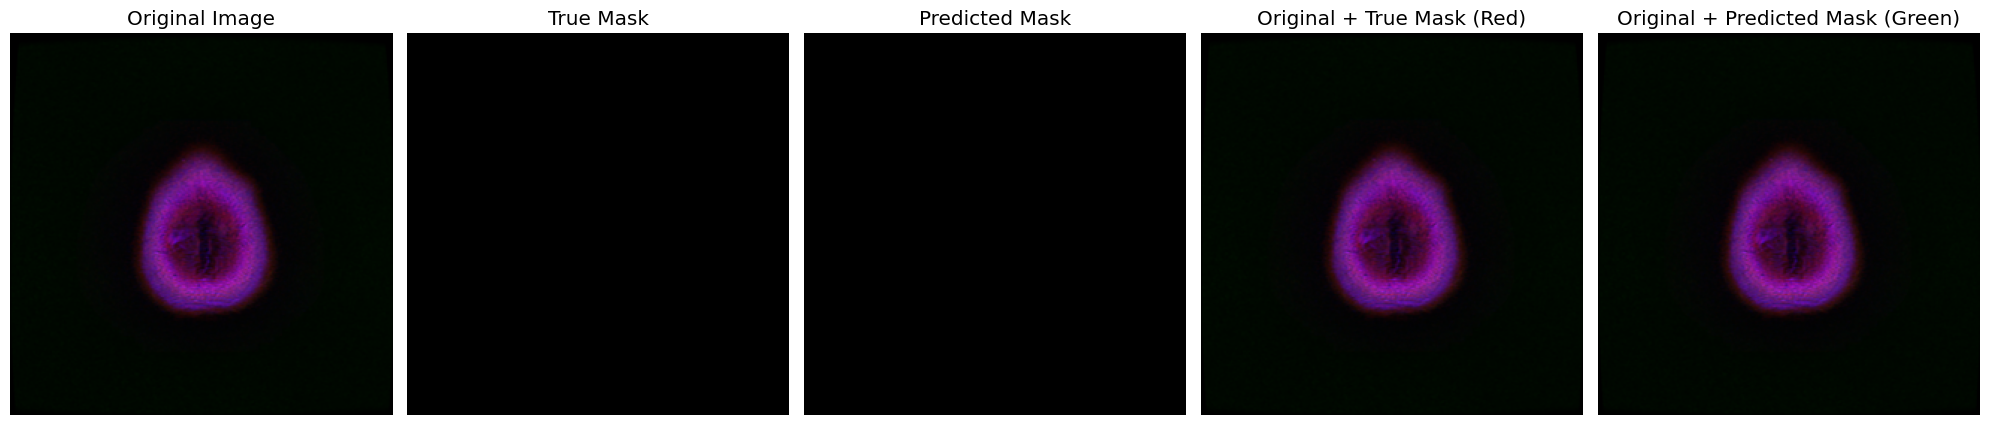

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


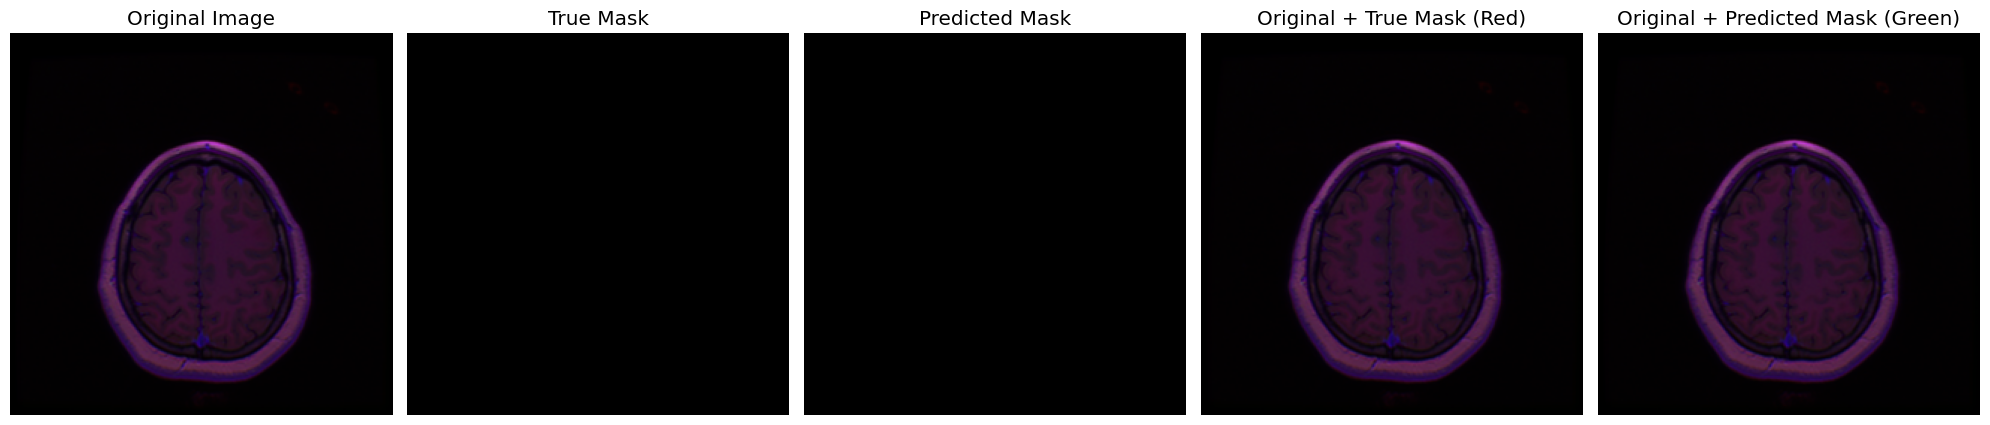

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


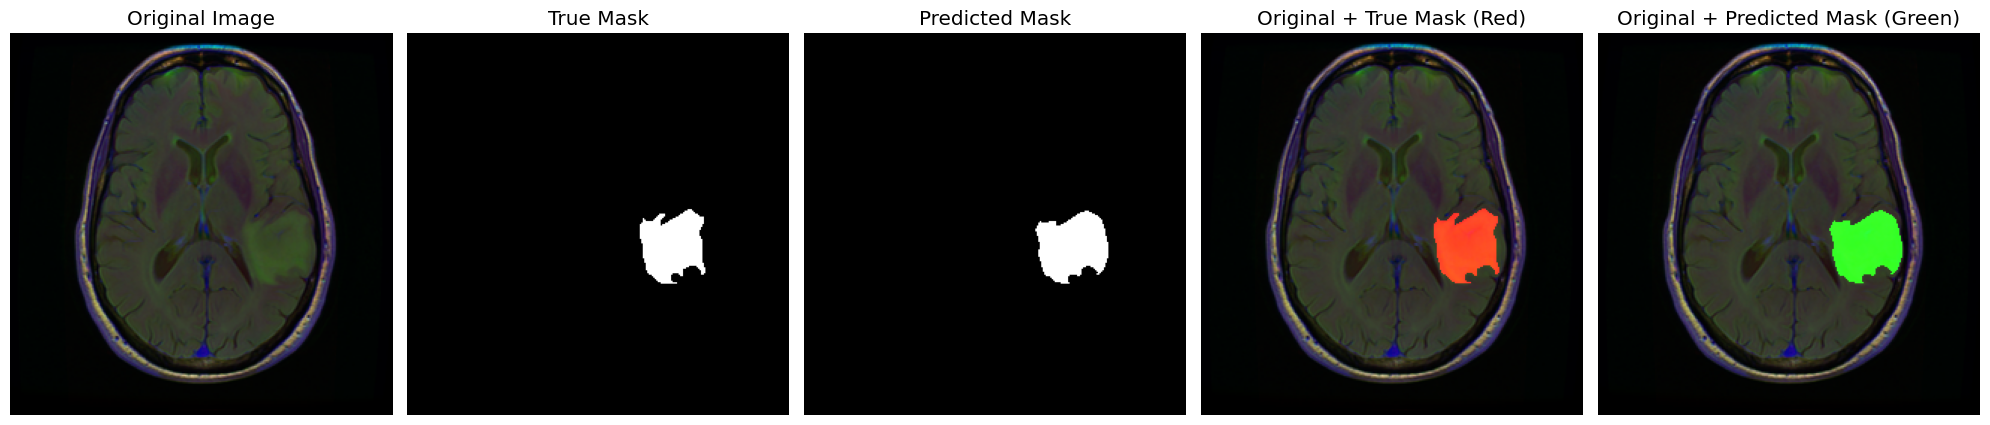

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


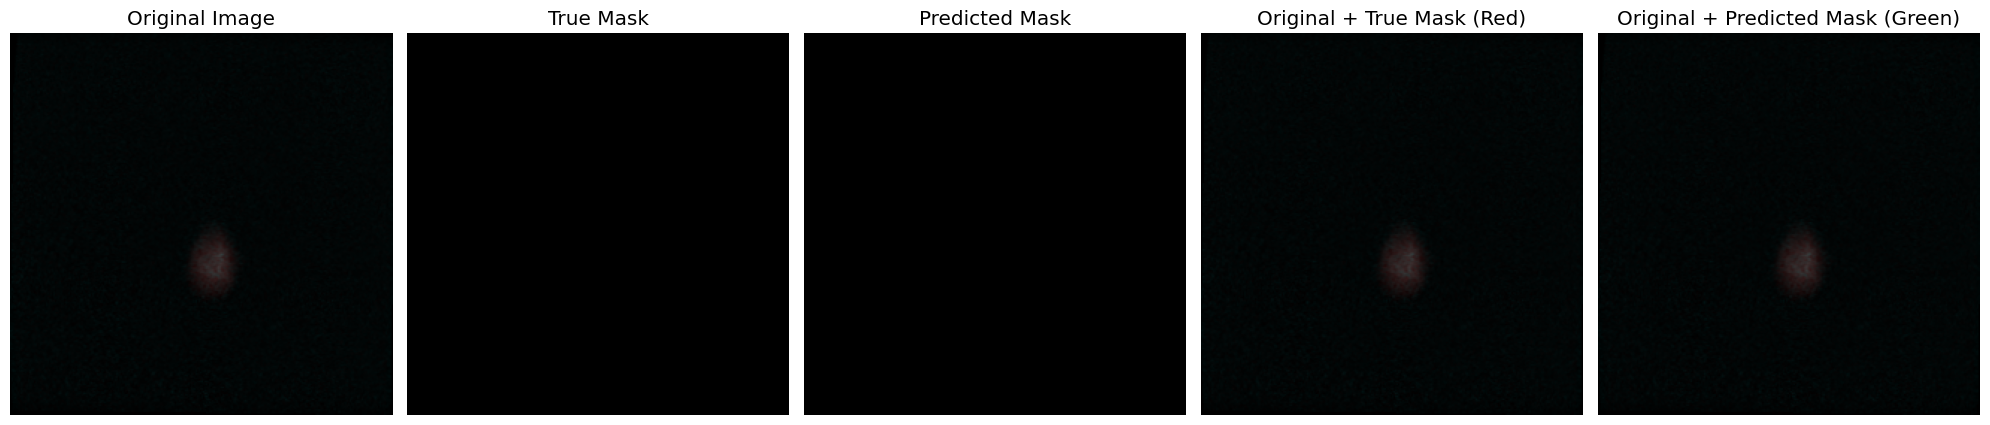

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    image, mask = next(test_generator)
    
    # Prédiction du masque
    predicted_mask = model.predict(image)

    # Binarisation du masque prédit avec un seuil de 0.5
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Création des images avec superpositions
    image_with_true_mask = image[0].copy()  
    image_with_predicted_mask = image[0].copy()  
    # Ajouter le masque réel en rouge
    image_with_true_mask[..., 0] = np.maximum(image_with_true_mask[..., 0], mask[0].squeeze() * 255)  # Rouge

    # Ajouter le masque prédit en vert
    image_with_predicted_mask[..., 1] = np.maximum(image_with_predicted_mask[..., 1], binary_predicted_mask[0].squeeze() * 255)  # Vert
    plt.figure(figsize=(20, 8))

    # Image originale
    plt.subplot(1, 5, 1)
    plt.title("Original Image")
    plt.imshow(image[0])
    plt.axis("off")

    # Masque réel
    plt.subplot(1, 5, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 5, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Image + True Mask
    plt.subplot(1, 5, 4)
    plt.title("Original + True Mask (Red)")
    plt.imshow(image_with_true_mask)
    plt.axis("off")

    # Image + Predicted Mask
    plt.subplot(1, 5, 5)
    plt.title("Original + Predicted Mask (Green)")
    plt.imshow(image_with_predicted_mask)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
